In [1]:
from pathlib import Path
import subprocess
from collections import namedtuple

# external modules 
import requests
import pandas as pd
from Bio import SeqIO

In [100]:
def cassettes_headers_to_df(multifasta_proteins):
    cmd = ['zgrep', '-Po', '(?<=^\>).+', multifasta_proteins]
    columns = ['contigs', 'cassettes', 'locus_tags', 'headers']
    data = []
    for header in subprocess.run(cmd, check=True, stdout=subprocess.PIPE).stdout.decode('UTF-8').splitlines():
        rows = header.split(':')
        assert len(rows) == 3, 'Header {} is invalid !'.format(header)
        rows.append(header)
        data.append(rows)
        
    df = pd.DataFrame(data=data, columns=columns) \
            .assign(genome_ids = lambda x: x['contigs'].str.split(':') \
                .apply(lambda x: '_'.join(x[0].split('_')[1:-1])))
    return df


                
def get_edges(topology: list, drop_duplicates=True):
    edges = []
    for indx, cluster_id in enumerate(topology):
        if indx == 0:
            edges.append((cluster_id, topology[indx+1]))
        elif indx == len(topology) - 1:
            edges.append((cluster_id, topology[indx-1]))
        else:
            edges.append((cluster_id, topology[indx-1]))
            edges.append((cluster_id, topology[indx+1]))
    if not drop_duplicates:
        return edges
    
    strict_edges = []
    for edge in edges:
        if not ( edge in strict_edges or edge[::-1] in strict_edges ):
            strict_edges.append(edge)
    return strict_edges

def get_wanted_locus_tags_from_gbk(gbk_path: str, wanted_locus_tags: list):
    with open(gbk_path) as f:
        features = []
        for record in SeqIO.parse(gbk_path, 'genbank'):
            for feature in filter(lambda fet: fet.qualifiers.get('locus_tag', [None])[0] in wanted_locus_tags, record.features):
                features.append((feature.qualifiers.get('locus_tag', [None])[0], feature))
        return pd.DataFrame(data=features, columns=['locus_tags', 'features'])
    
def list_gbk_files(annotation_dir: str) -> dict:
    cmd = [
        'find',
        annotation_dir,
        '-type', 'f',
        '-name', '*.gbk'
    ]
    files = {}
    for file in subprocess.run(cmd, check=True, stdout=subprocess.PIPE).stdout.decode('UTF-8').splitlines():
        file = Path(file)
        genome_id = file.stem.replace('_out', '')
        genome_path = str(file.absolute())
        assert not files.get(genome_id), 'Repeated ids: {}'.format(genome_id)
        files[genome_id] = genome_path
        
    return files

def get_feature_df(genome_filters: list, annotation_dir: str):
    """genome_filter = { genome_id : locus_tags }"""
    genome_paths: dict = list_gbk_files(annotation_dir)
    
    features_df = pd.DataFrame()
    for genome_id, locus_tags in genome_filters.items():
        df = get_wanted_locus_tags_from_gbk(gbk_path=genome_paths[genome_id], wanted_locus_tags=locus_tags)
        if features_df.empty:
            features_df = df
            continue
        features_df = pd.concat([features_df, df])
        
    return features_df.reset_index(drop=True)
        
            
            
def get_feature_string(feature):
    get_qualifier = lambda query: feature.qualifiers.get(query, ['NA'])[0]
    fields = ('gene', 'locus_tag', 'product', 'translation')
    return ';'.join(list(map(lambda field: '='.join((field, get_qualifier(field))) , fields)))


def read_and_merge_predictions(defense_system_prediction_dir: str):
    cmd = [
        'find',
        annotation_dir,
        '-type', 'f',
        '-name', '*merged_defense_systems_prediction.csv',
        '!', '-empty'
    ]
    
    prediction_files: list = subprocess.run(cmd, check=True, stdout=subprocess.PIPE).stdout.decode('UTF-8').splitlines()
    read_dataframe = lambda file_path: pd.read_csv(file_path, sep=',')
    
    return pd.concat(map(read_dataframe, prediction_files)).reset_index(drop=True)
    
    
    

In [107]:
multifasta_proteins = '../../results/cassettes/clusters/merged_cassette_proteins.faa.gz'
clusters = '../../results/cassettes/clusters/mmseqs2_cluster.tsv'
annotation_dir = '../../results/Prokka/'
defense_system_prediction_dir = '../../results/cassettes/extracted/'

## NEW

In [4]:
clusters_df = pd.DataFrame()
for rep, df in pd.read_csv(clusters, sep='\t', header=None).rename(columns={0:'representatives', 1:'members'}).groupby('representatives'):
    # is gene of interest 
    is_GOI = any(df.members.apply(lambda header: 'GOI_True' in header))
    members =  df.members.values
    df = pd.DataFrame(data=[(rep, members, len(members), is_GOI)], columns=[*df.columns, 'members_count', 'is_GOI']).set_index('representatives')
    if clusters_df.empty:
        clusters_df = df
        continue
    clusters_df = pd.concat([clusters_df, df])

clusters_df.sort_values(['members_count'], ascending=False).query('is_GOI').head()

,members,members_count,is_GOI
representatives,,,
Contig_1395103.4_47:Cassette_1:GOI_True:KDHGNBDG_03652,[Contig_1395103.4_47:Cassette_1:GOI_True:KDHGN...,12,True
Contig_936157.3_6:Cassette_1:GOI_True:IOMDNFNB_00334,[Contig_936157.3_6:Cassette_1:GOI_True:IOMDNFN...,10,True
Contig_936157.3_23:Cassette_1:GOI_True:IOMDNFNB_01072,[Contig_936157.3_23:Cassette_1:GOI_True:IOMDNF...,10,True
Contig_936157.3_6:Cassette_1:GOI_True:IOMDNFNB_00333,[Contig_936157.3_6:Cassette_1:GOI_True:IOMDNFN...,10,True
Contig_590.17131_2:Cassette_2:GOI_True:HOHECEAN_01191,[Contig_590.17131_2:Cassette_2:GOI_True:HOHECE...,8,True


In [5]:
genome_filters: dict = clusters_df.index.to_series().str.split(':', expand=True).iloc[:,[0,-1]] \
    .rename(columns={0: 'genome_id', 3: 'locus_tags'}) \
    .assign( genome_id = lambda df: df.genome_id.str.replace('Contig_', '').apply(lambda g_id: '_'.join(g_id.split('_')[:-1]) ) ) \
    .groupby('genome_id') \
    .apply(lambda df: pd.DataFrame(data=[[df.iloc[0,0], set(df.locus_tags.values.tolist())]], columns=['genome_id', 'locus_tags'] )) \
    .set_index('genome_id', drop=True).locus_tags.to_dict()

In [6]:
features = get_feature_df(genome_filters=genome_filters, annotation_dir=annotation_dir) \
            .assign(features = lambda df: df.features.apply(lambda fet: get_feature_string(fet))) \
            .set_index('locus_tags', drop=True).features.to_dict()

In [7]:
clusters_df = clusters_df \
    .assign(features = lambda df: df.index.to_series().str.split(':', expand=True).iloc[:,-1].apply(lambda locus_tag: features.get(locus_tag, 'NA')) ) \
    .assign(
        cluster_ids = lambda df: df.index.to_series().str.split(':', expand=True).iloc[:,-1] + 
        '_' + 
        df.features.str.split(';', expand=True).iloc[:,0].str.replace('gene=', '') 
    )

In [8]:
clusters_df.head()

,members,members_count,is_GOI,features,cluster_ids
representatives,,,,,
Contig_1395103.4_28:Cassette_1:GOI_False:KDHGNBDG_02934,[Contig_1395103.4_28:Cassette_1:GOI_False:KDHG...,1,False,gene=prpD;locus_tag=KDHGNBDG_02934;product=2-m...,KDHGNBDG_02934_prpD
Contig_1395103.4_28:Cassette_1:GOI_False:KDHGNBDG_02935,[Contig_1395103.4_28:Cassette_1:GOI_False:KDHG...,1,False,gene=prpC;locus_tag=KDHGNBDG_02935;product=2-m...,KDHGNBDG_02935_prpC
Contig_1395103.4_28:Cassette_1:GOI_False:KDHGNBDG_02947,[Contig_1395103.4_28:Cassette_1:GOI_False:KDHG...,1,False,gene=NA;locus_tag=KDHGNBDG_02947;product=hypot...,KDHGNBDG_02947_NA
Contig_1395103.4_28:Cassette_1:GOI_False:KDHGNBDG_02948,[Contig_1395103.4_28:Cassette_1:GOI_False:KDHG...,1,False,gene=NA;locus_tag=KDHGNBDG_02948;product=hypot...,KDHGNBDG_02948_NA
Contig_1395103.4_28:Cassette_1:GOI_False:KDHGNBDG_02949,[Contig_1395103.4_28:Cassette_1:GOI_False:KDHG...,1,False,gene=NA;locus_tag=KDHGNBDG_02949;product=Elect...,KDHGNBDG_02949_NA


In [90]:
nodes = clusters_df.loc[:, ['cluster_ids', 'members_count', 'is_GOI', 'features']] \
    .reset_index(drop=True) \
    .assign(group = lambda df: df.is_GOI.apply(lambda x: 'GOI' if x else 'NA')) \
    .rename(columns={'cluster_ids' : 'id'})

nodes.query('group != "NA"').head()

,id,members_count,is_GOI,features,group
33,KDHGNBDG_03651_ecoRIIR,2,True,gene=ecoRIIR;locus_tag=KDHGNBDG_03651;product=...,GOI
34,KDHGNBDG_03652_dcm_2,12,True,gene=dcm_2;locus_tag=KDHGNBDG_03652;product=DN...,GOI
35,KDHGNBDG_03655_NA,1,True,gene=NA;locus_tag=KDHGNBDG_03655;product=hypot...,GOI
54,KDHGNBDG_00483_rep_2,1,True,gene=rep_2;locus_tag=KDHGNBDG_00483;product=AT...,GOI
55,KDHGNBDG_00484_NA,1,True,gene=NA;locus_tag=KDHGNBDG_00484;product=hypot...,GOI


In [10]:
import itertools

ids_df = clusters_df.loc[:, ['cluster_ids', 'members']].reset_index(drop=True).explode('members') \
    .assign(locus_tags =  lambda df: df.members.str.split(':', expand=True).iloc[:,[-1]].values ).drop(['members'], axis=1)

cassettes_gdf = pd.Series(data=list(itertools.chain.from_iterable(clusters_df.members)), name='members') \
    .str.split(':', expand=True) \
    .rename(columns=dict(zip(range(4), ['contigs', 'cassettes', 'GOI', 'locus_tags'] ))) \
    .merge(ids_df, on='locus_tags', how='left').groupby(['contigs', 'cassettes'])    

In [215]:

edges = pd.DataFrame()

for cassette, df in cassettes_gdf:
    # Making shore these locus_tags are sorted !!!!!!
    df = df.sort_values('locus_tags', key = lambda locus_tags: locus_tags.apply(lambda locus_tag: int(locus_tag.split('_')[-1]) ))
    cassette_edges = pd.DataFrame(data=get_edges(df.cluster_ids.values), columns=['source', 'target'])
    if edges.empty:
        edges = cassette_edges
        continue
    edges = pd.concat([edges, cassette_edges])
    
edges = edges.reset_index(drop=True)


# Merge equal edges and count: [(A -> B), (B -> A), (A -> B), (A -> B), (B -> A), (A -> B)] = (A -> B) 6
edges = edges.assign(sorted_edges = lambda df: list(map(
    lambda tups: sorted(set(itertools.chain.from_iterable(tups))),
    tuple(zip(df.iloc[:,[0,1]].values.tolist(), df.iloc[:,[1,0]].values.tolist())))
                                           )) \
    .assign(source = lambda df: df.sorted_edges.apply(lambda x: x[0])) \
    .assign(target = lambda df: df.sorted_edges.apply(lambda x: x[1])) \
    .drop('sorted_edges', axis=1) \
    .groupby(['source', 'target'], as_index=False).size() \
    .sort_values('size', ascending=False) \
    .rename(columns={'size' : 'edge_count'}).reset_index(drop=True)
edges.head()

,source,target,edge_count
0,IOMDNFNB_00343_prpR,IOMDNFNB_00344_prpB,10
1,IOMDNFNB_00332_yjhB_1,IOMDNFNB_00333_NA,10
2,IOMDNFNB_01075_NA,IOMDNFNB_01076_dgcQ,10
3,IOMDNFNB_01076_dgcQ,IOMDNFNB_01077_yedP,10
4,IOMDNFNB_01072_vsr,IOMDNFNB_01073_yedA,10


In [108]:
defense_system_prediction_df = read_and_merge_predictions(defense_system_prediction_dir)
defense_system_prediction_df.head()

,locus_tags,names,systems,tool
0,BKDLJELO_00330,MTase_I,DMS_other,padloc
1,BKDLJELO_00330,MTase_I,RM_type_I,padloc
2,BKDLJELO_00331,Specificity_I,DMS_other,padloc
3,BKDLJELO_00331,Specificity_I,RM_type_I,padloc
4,BKDLJELO_00332,REase_I,DMS_other,padloc


In [201]:
get_defense_string = lambda locus_tag, df: (locus_tag, ';'.join(map(lambda z: ':'.join((z[-1], ','.join(z[1:-1]))), map(lambda y: tuple(map('='.join, y)) , map(lambda x: zip(*x), zip(itertools.repeat(df.columns.tolist()) , df.values.tolist())) ))))
defense_system_prediction_mask = pd.DataFrame(
    map(lambda args: get_defense_string(*args), defense_system_prediction_df.fillna('NA').groupby('locus_tags')),
    columns=('locus_tags', 'defense_prediction')
).set_index('locus_tags', drop=True).defense_prediction.to_dict()
list(defense_system_prediction_mask.items())[0]

('ACCAFLOF_00774',
 'tool=padloc:names=oMTase,systems=DMS_other;tool=padloc:names=MTase_II,systems=RM_type_II')

In [209]:
nodes = nodes.assign( defense_system_prediction = lambda df: df.features.apply(lambda x: defense_system_prediction_mask.get(x.split(';')[1].replace('locus_tag=', ''), 'NA')) )
nodes.query('defense_system_prediction != "NA"').head()

,id,members_count,is_GOI,features,group,defense_system_prediction
33,KDHGNBDG_03651_ecoRIIR,2,True,gene=ecoRIIR;locus_tag=KDHGNBDG_03651;product=...,GOI,"tool=padloc:names=REase_II,systems=DMS_other;t..."
34,KDHGNBDG_03652_dcm_2,12,True,gene=dcm_2;locus_tag=KDHGNBDG_03652;product=DN...,GOI,"tool=padloc:names=MTase_II,systems=DMS_other;t..."
35,KDHGNBDG_03655_NA,1,True,gene=NA;locus_tag=KDHGNBDG_03655;product=hypot...,GOI,"tool=padloc:names=Control_protein,systems=DMS_..."
54,KDHGNBDG_00483_rep_2,1,True,gene=rep_2;locus_tag=KDHGNBDG_00483;product=AT...,GOI,"tool=padloc:names=GajB,systems=gabija;tool=def..."
55,KDHGNBDG_00484_NA,1,True,gene=NA;locus_tag=KDHGNBDG_00484;product=hypot...,GOI,"tool=padloc:names=GajA,systems=gabija;tool=def..."


In [318]:
import requests
import py4cytoscape as p4c

exec(requests.get("https://raw.githubusercontent.com/cytoscape/jupyter-bridge/master/client/p4c_init.py").text)
IPython.display.Javascript(_PY4CYTOSCAPE_BROWSER_CLIENT_JS) # Start browser client
p4c.cytoscape_ping()
p4c.cytoscape_version_info()


Skip reloading Javascript client ... 4e0fe53d-ac61-4bc6-908b-04b12d7c8261 on https://jupyter-bridge.cytoscape.org
You are connected to Cytoscape!


{'apiVersion': 'v1',
 'cytoscapeVersion': '3.9.1',
 'automationAPIVersion': '1.6.0',
 'py4cytoscapeVersion': '1.5.0'}

In [319]:
p4c.create_network_from_data_frames(nodes, edges, title="Salmonella Bacterial Immunity", collection="Salmonella")

Applying default style...
Applying preferred layout


124

In [321]:
p4c.set_node_shape_default('ELLIPSE')
p4c.layout_network('kamada-kawai')

style_name not specified, so updating "default" style.


{}

In [322]:
# Fix sizes (min 10, max 260)
min_size = 20
max_size = 260
factor = 10
p4c.load_table_data(p4c.get_table_columns().assign(members_count  = lambda df: df.members_count.apply(lambda x: min(max_size, max(min_size, factor * x)))).loc[:,['name', 'members_count']].set_index('name', drop=True))

'Success: Data loaded in defaultnode table'

In [342]:
node_size_map = p4c.map_visual_property('NODE_SIZE', 'members_count', 'p')
p4c.update_style_mapping('default', node_size_map)

''

In [339]:
p4c.cyrest_get()


{'allAppsStarted': True,
 'apiVersion': 'v1',
 'numberOfCores': 4,
 'memoryStatus': {'usedMemory': 809,
  'freeMemory': 1238,
  'totalMemory': 2048,
  'maxMemory': 6604}}

In [399]:
import re
def get_defense_name(prediction_string: str):
    if prediction_string == 'NA':
        return 'NA'
    
    systems = re.findall('(?<=systems\=).+?(?=\;)', prediction_string)
    
    if not systems:
        return 'NA'
    
    return list(map(lambda x: x.upper().split('_')[0], systems))[0]
    
defense_map_df =  p4c.get_table_columns().set_index('name', drop=True).loc[:,['defense_system_prediction']] \
    .assign(defense_map = lambda df: df.defense_system_prediction.apply(lambda x: get_defense_name(x))).query('defense_map != "NA"') \
    .loc[:, ['defense_map']]

In [401]:
p4c.load_table_data(defense_map_df)

'Success: Data loaded in defaultnode table'

In [403]:
p4c.set_node_color_mapping(**p4c.gen_node_color_map('defense_map', mapping_type='d', style_name='default'))

''

,color
defense_map,
DRT,#F9D448
CAS,#D0BDA1
DMS,#B3B3B3
DSR1,#BEA37E
GABIJA,#AB99C8


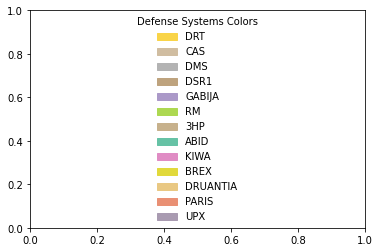

In [522]:
# p4c.get_node_property(visual_property='NODE_FILL_COLOR', node_names=nv1)
# COLORS
colors_df = p4c.get_table_columns().loc[:,['id', 'defense_map']].dropna().groupby('defense_map', as_index=False).pipe(lambda df: df.head(1)) \
    .assign(color = lambda df: tuple(map(lambda cluster_id: tuple(p4c.get_node_color(cluster_id).values())[0], df.id.values.tolist()))) \
    .iloc[:, 1:].drop_duplicates().set_index('defense_map', drop=True)

plt.legend(
    handles=[mpatches.Patch(color=color, label=system)  for system, color in colors_df.color.to_dict().items()],
    loc='center', frameon=False, title='Defense Systems Colors'
)
colors_df.head()

In [539]:
min_edge_size = 3

p4c.get_table_columns(table='edge').query('edge_count >= @min_edge_size').head()

,SUID,shared name,shared interaction,name,selected,interaction,source,target,edge_count,data.key.column
2051,2051,IOMDNFNB_00332_yjhB_1 (interacts with) IOMDNFN...,interacts with,IOMDNFNB_00332_yjhB_1 (interacts with) IOMDNFN...,False,interacts with,IOMDNFNB_00332_yjhB_1,IOMDNFNB_00333_NA,10,2051
2054,2054,IOMDNFNB_01075_NA (interacts with) IOMDNFNB_01...,interacts with,IOMDNFNB_01075_NA (interacts with) IOMDNFNB_01...,False,interacts with,IOMDNFNB_01075_NA,IOMDNFNB_01076_dgcQ,10,2054
2057,2057,IOMDNFNB_01076_dgcQ (interacts with) IOMDNFNB_...,interacts with,IOMDNFNB_01076_dgcQ (interacts with) IOMDNFNB_...,False,interacts with,IOMDNFNB_01076_dgcQ,IOMDNFNB_01077_yedP,10,2057
2060,2060,IOMDNFNB_01072_vsr (interacts with) IOMDNFNB_0...,interacts with,IOMDNFNB_01072_vsr (interacts with) IOMDNFNB_0...,False,interacts with,IOMDNFNB_01072_vsr,IOMDNFNB_01073_yedA,10,2060
2063,2063,IOMDNFNB_01077_yedP (interacts with) IOMDNFNB_...,interacts with,IOMDNFNB_01077_yedP (interacts with) IOMDNFNB_...,False,interacts with,IOMDNFNB_01077_yedP,IOMDNFNB_01078_NA,10,2063


In [536]:
help(p4c.create_degree_filter) # ('degree filter', [0, 2], predicate='IS_NOT_BETWEEN')


Help on function create_degree_filter in module py4cytoscape.filters:

create_degree_filter(filter_name, criterion, predicate='BETWEEN', edge_type='ANY', hide=False, network=None, base_url='http://127.0.0.1:1234/v1', *, apply=True)
    Create Degree Filter.
    
    Creates a filter to control node selection base on in/out degree.
    
    Args:
        filter_name (str): Name for new filter.
        criterion (list): A two-element vector of numbers, example: [1,5].
        predicate (str):  BETWEEN (default) or IS_NOT_BETWEEN
        edgeType (str): Type of edges to consider in degree count: ANY (default), UNDIRECTED, INCOMING, OUTGOING, DIRECTED
        hide (bool): Whether to hide filtered out nodes and edges. Default is FALSE.
            Ignored if all nodes or edges are filtered out. This is an alternative to filtering for node and edge selection.
        network (SUID or str or None): Name or SUID of the network. Default is the "current" network active in Cytoscape.
        base

In [547]:
p4c.create_column_filter('persistence', 'edge_count', min_edge_size, 'GREATER_THAN_OR_EQUAL', type='edges')
p4c.create_subnetwork(subnetwork_name='Salmonella Bacterial Immunity (filtered min_persistence: {})'.format(str(min_edge_size)))

No nodes selected.


6694

In [546]:
help(p4c.create_subnetwork)

Help on function create_subnetwork in module py4cytoscape.networks:

create_subnetwork(nodes=None, nodes_by_col='SUID', edges=None, edges_by_col='SUID', exclude_edges=False, subnetwork_name=None, network=None, base_url='http://127.0.0.1:1234/v1')
    Copies a subset of nodes and edges into a newly created subnetwork.
    
    Args:
        nodes (str or list or int or None): List of nodes or keyword: selected, unselected or all. If node list:
            ``list`` of node names or SUIDs, comma-separated string of node names or SUIDs, or scalar node name
            or SUID. Node names should be found in the ``SUID`` column of the ``node table`` unless
            specified in ``nodes_by_col``. If list is None, default is currently selected nodes.
        nodes_by_col (str): name of node table column corresponding to provided nodes list; default is 'SUID'
        edges (str or list or int or None): List of edges or keyword: selected, unselected or all. If edge list:
            ``list`` 